In [21]:
import numpy as np
import random
import collections

import tqdm
%matplotlib inline
import matplotlib.pyplot as plt
from IPython import display

import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader

from torchvision import datasets, transforms
from util import *

#### CIFAR-10 dataset

CIFAR-10 dataset contains 32x32 color images from 10 classes: __airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck__

In [2]:
# Convert from PIL to torch.Tensort
# and normalize each pixel from [0, 255] range to [0.0, 1.0]
base_transforms = transforms.ToTensor()

# An augmentation that randomly (with a probability equal to 0.5)
# flips the image horizontally
# This will prevent overfitting and make the model more robust
aug_transforms = transforms.RandomHorizontalFlip(p=0.5)

# Gather all transforms together
train_transforms = transforms.Compose([
    base_transforms,
    aug_transforms
])

train_dataset = datasets.CIFAR10('./', train=True, download=True, transform=train_transforms)

# Note that we only use `base_transforms` for test dataset
test_dataset = datasets.CIFAR10('./', train=False, download=True, transform=base_transforms)

100%|██████████| 170498071/170498071 [00:33<00:00, 5034941.81it/s]


Extracting ./cifar-10-python.tar.gz to ./
Files already downloaded and verified


In [12]:
BATCH_SIZE = 32

# `pin_memory` speed up processing if you use GPU
# `num_workers` also speed up processing since use additional process
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,
                              num_workers=0, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE,
                             num_workers=0, pin_memory=True)

Data example:

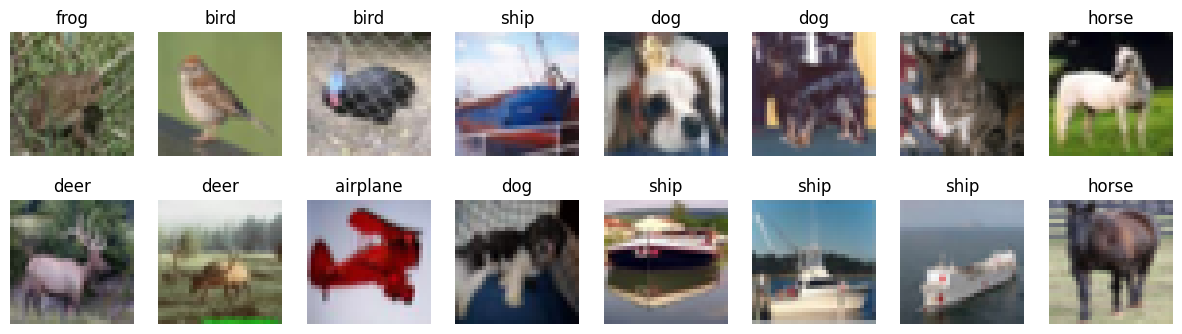

In [11]:
index2class = {v: k for k, v in train_dataset.class_to_idx.items()}
cols, rows = 8, 2
fig = plt.figure(figsize=(2 * cols - 1, 2.5 * rows - 1))

for i in range(cols):
    for j in range(rows):
        random_index = random.randint(0, len(train_dataset) - 1)
        
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        
        image, label = train_dataset[random_index]
        
        # move the channel dimension to the end
        images = image.permute(1, 2, 0)
        
        ax.imshow(images)
        ax.set_title(index2class[label])

plt.show()

#### CNN as a reference implementation

Convolutional networks are built from several types of layers:
- [Conv2D](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html) - performs convolution:
- [MaxPool2d](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html) - performs 2D max pooling.
- [Flatten](https://pytorch.org/docs/stable/generated/torch.nn.Flatten.html) - flattens the input, does not affect the batch size.
- [Linear](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html) - fully-connected layer.
- [LeakyReLU](https://pytorch.org/docs/stable/generated/torch.nn.LeakyReLU.html) - applies leaky relu activation.
- [Dropout](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html) - applies dropout.

In [13]:
def make_model():
    """
    Define your model architecture here.
    Returns `Sequential` model.
    """
    
    model = nn.Sequential(
        # define layers

        ### YOUR CODE HERE ###
        nn.Conv2d(in_channels=3, out_channels=16, kernel_size=(3, 3), padding='same'),
        nn.LeakyReLU(0.1),
        nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding='same'),
        nn.LeakyReLU(0.1),
        nn.MaxPool2d(kernel_size = (2,2)),
        nn.Dropout(0.25),
        nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), padding='same'),
        nn.LeakyReLU(0.1),
        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding='same'),
        nn.LeakyReLU(0.1),
        nn.MaxPool2d(kernel_size = (2,2)),
        nn.Dropout(0.25),
        nn.Flatten(),
        nn.Linear(4096, 256),
        nn.LeakyReLU(0.1),
        nn.Dropout(0.5),
        nn.Linear(256, 10)        
    )
    
    # Don't add Softmax or something else to the end!
    # We will use nn.CrossEntropyLoss which does this itself.
    
    return model

Cross-entropy loss and stochastic gradient descent optimiser are used. Descent is performed in number of epochs, no stop-criterion for gradient descent. Accuracy is a metric for the learninng process.

In [17]:
NUM_EPOCH = 50
DEVICE = torch.device('cpu:0')
HISTORY = collections.defaultdict(list)

model = make_model().to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-2, momentum=0.9, nesterov=True)

# Set up learning rate scheduler
# This will speed up the convergence of the model
lr_scheduler = optim.lr_scheduler.MultiStepLR(
    optimizer=optimizer,
    milestones=[20, 40],
    gamma=0.1,
    verbose=True
)

Adjusting learning rate of group 0 to 1.0000e-02.


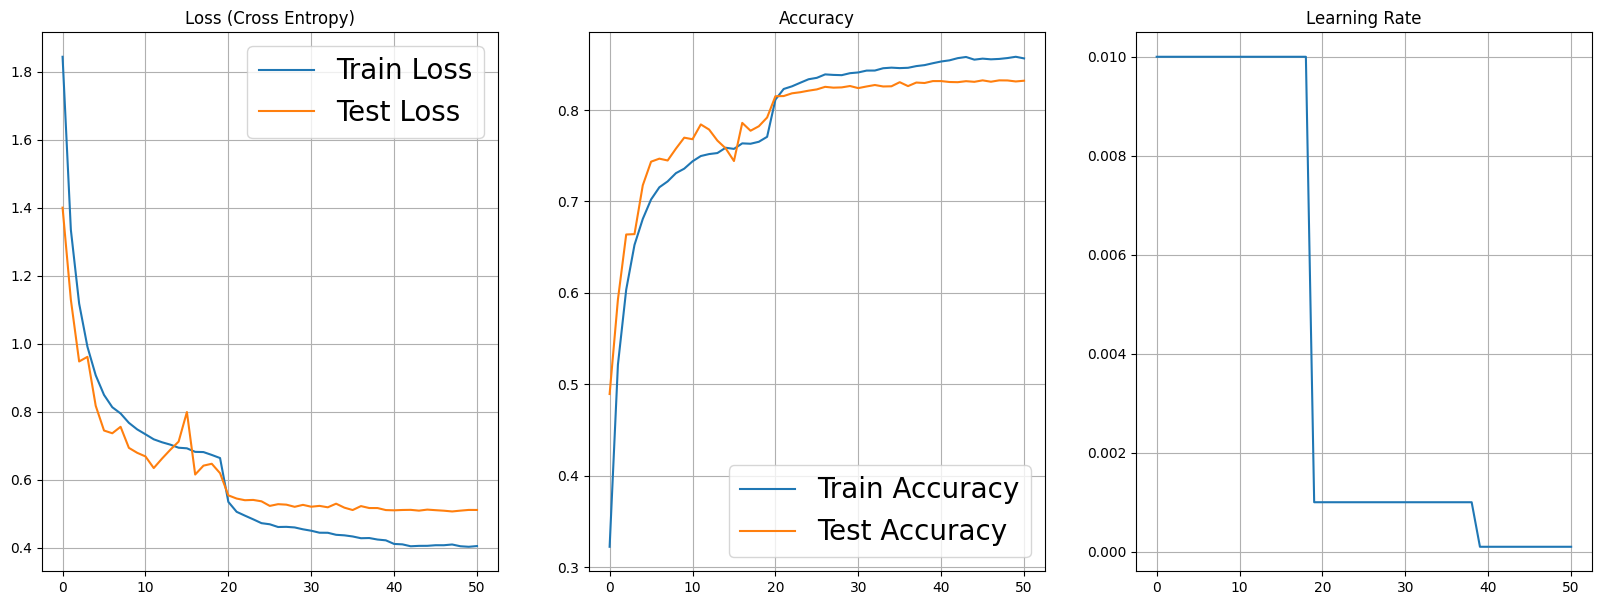

In [22]:
for epoch in range(NUM_EPOCH):
    # AverageMeter will accumulate average of some metric
    train_loss_meter, train_accuracy_meter, test_loss_meter, test_accuracy_meter \
        = AverageMeter(), AverageMeter(), AverageMeter(), AverageMeter()
    
    # training loop
    # sets the module in training mode -- it is important for nn.Dropout
    model.train()
    # wrap `train_dataloader` within tqdm to visualize progress
    for train_batch in tqdm.tqdm(train_dataloader):
        
        # unpack batch and move to specific device (for example, GPU or TPU)
        images, labels = train_batch
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)
        
        # do forward pass
        logits = model(images)
        prediction = logits.argmax(dim=-1)
        
        # calculate loss (CrossEntropy)
        loss = criterion(logits, labels)
        # zero out the previous gradients of our model parameters
        optimizer.zero_grad()
        # calculate new gradients
        loss.backward()
        # do optimization step
        optimizer.step()
        
        # calculate current average loss and accuracy
        train_loss_meter.update(loss.item())
        train_accuracy_meter.update(
            calculate_accuracy(
                prediction.detach(),
                labels
            ).item()
        )
    
    # update lr_scheduler
    lr_scheduler.step()
        
    # save average train loss and accuracy
    HISTORY['train_loss'].append(train_loss_meter.avg)
    HISTORY['train_accuracy'].append(train_accuracy_meter.avg)
    
    # lr_scheduler.get_last_lr() return list of LRs (one LR for each group)
    HISTORY['learning_rate'].append(lr_scheduler.get_last_lr()[0])
        
    # testing loop
    # sets the module in evaluation mode
    model.eval()
    for test_batch in test_dataloader:
        images, labels = test_batch
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)
        
        # аdd `with torch.no_grad()' to avoid computing gradients of weights
        with torch.no_grad():
            # do everything like we did in training loop
            logits = model(images)
            prediction = logits.argmax(dim=-1)
            loss = criterion(logits, labels)
        
        test_loss_meter.update(loss.item())
        test_accuracy_meter.update(
            calculate_accuracy(
                prediction,
                labels
            ).item()
        )
    
    # save average test accuracy loss and accuracy
    HISTORY['test_loss'].append(test_loss_meter.avg)
    HISTORY['test_accuracy'].append(test_accuracy_meter.avg)
    
    # visualize all togather
    display.clear_output()
    fig, axes = plt.subplots(1, 3, figsize=(20, 7))
    
    axes[0].set_title('Loss (Cross Entropy)')
    axes[0].plot(HISTORY['train_loss'], label='Train Loss')
    axes[0].plot(HISTORY['test_loss'], label='Test Loss')
    axes[0].grid()
    axes[0].legend(fontsize=20)
    
    axes[1].set_title('Accuracy')
    axes[1].plot(HISTORY['train_accuracy'], label='Train Accuracy')
    axes[1].plot(HISTORY['test_accuracy'], label='Test Accuracy')
    axes[1].grid()
    axes[1].legend(fontsize=20)
    
    axes[2].set_title('Learning Rate')
    axes[2].plot(HISTORY['learning_rate'])
    axes[2].grid()
    
    plt.show()
